# Copy from https://www.kaggle.com/code/mayukh18/pytorch-fog-end-to-end-baseline-lb-0-254
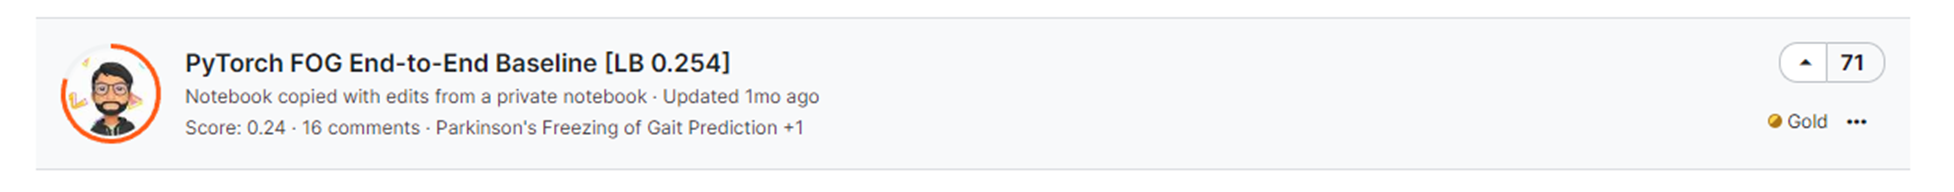

In [ ]:
import os
import gc
import random
import time
import matplotlib.pyplot as plt

import json
from tqdm import tqdm
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import accuracy_score, average_precision_score

import warnings
warnings.filterwarnings(action='ignore')

# Config

In [ ]:
class Config:
    train_dir1 = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog"
    train_dir2 = "/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog"

    batch_size = 1024                                                        #batch size大小
    window_size = 32                                                         #每次Input的總時序資料長度
    window_future = 8                                                        #取目標時間點後多少為Input
    window_past = window_size - window_future                                #取目標時間點前多少為Input
    
    wx = 8                                                                   #資料padding長度的參數
    
    optimizer_name = "Adam"                                                  #optimizer
    loss_function = "BCEWithLogitsLoss"                                      #loss function
    
    model_dropout = 0.2                                                      #dropout機率
    model_hidden = 32                                                        #每層linear layer的神經元數
    model_nblocks = 1                                                        #model內的block數
    
    lr = 0.00015                                                             #learning rate
    num_epochs = 5                                                           #訓練的epochs數
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'                #裝置(GPU)設定
    
    feature_list = ['AccV', 'AccML', 'AccAP']
    label_list = ['StartHesitation', 'Turn', 'Walking']
    
    
cfg = Config()

In [ ]:
cfg.device

# Stratified Group K Fold

It's mentioned in the data that the subjects are different in the train and test set and even different between the public/private splits of the test data. So we need to use Stratified Group K Fold. But since the positive instances in the sequences are very scarce, we need to pick up the best fold which will give us the best balance of the positive/negative instances.

### tdcsfog preprocessing

In [ ]:
# Analysis of positive instances in each fold of our CV folds

n1_sum = []
n2_sum = []
n3_sum = []
count = []

# Here I am using the metadata file available during training. Since the code will run again during submission, if 
# I used the usual file from the competition folder, it would have been updated with the test files too.
metadata = pd.read_csv("/kaggle/input/copy-train-metadata/tdcsfog_metadata.csv")

for f in tqdm(metadata['Id']):
    fpath = f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/{f}.csv"
    df = pd.read_csv(fpath)
    
    n1_sum.append(np.sum(df['StartHesitation']))
    n2_sum.append(np.sum(df['Turn']))
    n3_sum.append(np.sum(df['Walking']))
    count.append(len(df))
    
print(f"32 files have positive values in all 3 classes")

metadata['n1_sum'] = n1_sum
metadata['n2_sum'] = n2_sum
metadata['n3_sum'] = n3_sum
metadata['count'] = count

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    
    print(f"Length of Train = {len(train_index)}, Length of Valid = {len(valid_index)}")
    n1_sum = metadata.loc[train_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[train_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[train_index, 'n3_sum'].sum()
    print(f"Train classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")
    
    n1_sum = metadata.loc[valid_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[valid_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[valid_index, 'n3_sum'].sum()
    print(f"Valid classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")
    
# FOLD 2 is the most well balanced
# The actual train-test split (based on Fold 2)

metadata = pd.read_csv("/kaggle/input/copy-train-metadata/tdcsfog_metadata.csv")
sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    if i != 2:
        continue
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
    
    if i == 2:
        break
        
train_fpaths_tdcs = [f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/{_id}.csv" for _id in train_ids]
valid_fpaths_tdcs = [f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/{_id}.csv" for _id in valid_ids]

### defog preprocessing

In [ ]:
# Analysis of positive instances in each fold of our CV folds

n1_sum = []
n2_sum = []
n3_sum = []
count = []

# Here I am using the metadata file available during training. Since the code will run again during submission, if 
# I used the usual file from the competition folder, it would have been updated with the test files too.
metadata = pd.read_csv("/kaggle/input/copy-train-metadata/defog_metadata.csv")
metadata['n1_sum'] = 0
metadata['n2_sum'] = 0
metadata['n3_sum'] = 0
metadata['count'] = 0

for f in tqdm(metadata['Id']):
    fpath = f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{f}.csv"
    if os.path.exists(fpath) == False:
        continue
        
    df = pd.read_csv(fpath)
    metadata.loc[metadata['Id'] == f, 'n1_sum'] = np.sum(df['StartHesitation'])
    metadata.loc[metadata['Id'] == f, 'n2_sum'] = np.sum(df['Turn'])
    metadata.loc[metadata['Id'] == f, 'n3_sum'] = np.sum(df['Walking'])
    metadata.loc[metadata['Id'] == f, 'count'] = len(df)
    
metadata = metadata[metadata['count'] > 0].reset_index()

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    
    print(f"Length of Train = {len(train_index)}, Length of Valid = {len(valid_index)}")
    n1_sum = metadata.loc[train_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[train_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[train_index, 'n3_sum'].sum()
    print(f"Train classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")
    
    n1_sum = metadata.loc[valid_index, 'n1_sum'].sum()
    n2_sum = metadata.loc[valid_index, 'n2_sum'].sum()
    n3_sum = metadata.loc[valid_index, 'n3_sum'].sum()
    print(f"Valid classes: {n1_sum:,}, {n2_sum:,}, {n3_sum:,}")
    
# FOLD 2 is the most well balanced
# The actual train-test split (based on Fold 2)

sgkf = StratifiedGroupKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, valid_index) in enumerate(sgkf.split(X=metadata['Id'], y=[1]*len(metadata), groups=metadata['Subject'])):
    if i != 1:
        continue
    print(f"Fold = {i}")
    train_ids = metadata.loc[train_index, 'Id']
    valid_ids = metadata.loc[valid_index, 'Id']
    print(f"Length of Train = {len(train_ids)}, Length of Valid = {len(valid_ids)}")
    
    if i == 2:
        break
        
train_fpaths_de = [f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{_id}.csv" for _id in train_ids]
valid_fpaths_de = [f"/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{_id}.csv" for _id in valid_ids]

In [ ]:
train_fpaths = [(f, 'de') for f in train_fpaths_de] + [(f, 'tdcs') for f in train_fpaths_tdcs]
valid_fpaths = [(f, 'de') for f in valid_fpaths_de] + [(f, 'tdcs') for f in valid_fpaths_tdcs]

# DataLoader

We use a window comprised of past and future time Acc readings to form our dataset for a particular time instance. In case some portion of the window data is not available, we pad them with zeros.

In [ ]:
class FOGDataset(Dataset):
    def __init__(self, fpaths, scale=9.806, split="train"):
        super(FOGDataset, self).__init__()
        tm = time.time()
        self.split = split
        self.scale = scale
        
        self.fpaths = fpaths
        self.dfs = [self.read(f[0], f[1]) for f in fpaths]
        self.f_ids = [os.path.basename(f[0])[:-4] for f in self.fpaths]
        
        self.end_indices = []
        self.shapes = []
        _length = 0
        for df in self.dfs:
            self.shapes.append(df.shape[0])
            _length += df.shape[0]
            self.end_indices.append(_length)
        
        self.dfs = np.concatenate(self.dfs, axis=0).astype(np.float16)
        self.length = self.dfs.shape[0]
        
        shape1 = self.dfs.shape[1]
        
        self.dfs = np.concatenate([np.zeros((cfg.wx*cfg.window_past, shape1)), self.dfs, np.zeros((cfg.wx*cfg.window_future, shape1))], axis=0)
        print(f"Dataset initialized in {time.time() - tm} secs!")
        gc.collect()
        
    def read(self, f, _type):
        df = pd.read_csv(f)
        if self.split == "test":
            return np.array(df)
        
        if _type =="tdcs":
            df['Valid'] = 1
            df['Task'] = 1
            df['tdcs'] = 1
        else:
            df['tdcs'] = 0
        
        return np.array(df)
            
    def __getitem__(self, index):
        if self.split == "train":
            row_idx = random.randint(0, self.length-1) + cfg.wx*cfg.window_past
        elif self.split == "test":
            for i,e in enumerate(self.end_indices):
                if index >= e:
                    continue
                df_idx = i
                break

            row_idx_true = self.shapes[df_idx] - (self.end_indices[df_idx] - index)
            _id = self.f_ids[df_idx] + "_" + str(row_idx_true)
            row_idx = index + cfg.wx*cfg.window_past
        else:
            row_idx = index + cfg.wx*cfg.window_past
            
        #scale = 9.806 if self.dfs[row_idx, -1] == 1 else 1.0
        x = self.dfs[row_idx - cfg.wx*cfg.window_past : row_idx + cfg.wx*cfg.window_future, 1:4]
        x = x[::cfg.wx, :][::-1, :]
        x = torch.tensor(x.astype('float'))#/scale
        
        t = self.dfs[row_idx, -3]*self.dfs[row_idx, -2]
        
        if self.split == "test":
            return _id, x, t
        
        y = self.dfs[row_idx, 4:7].astype('float')
        y = torch.tensor(y)
        
        return x, y, t
    
    def __len__(self):
        # return self.length
        if self.split == "train":
            return 5_000_000
        return self.length

In [ ]:
gc.collect()

# Model

In [ ]:
def _block(in_features, out_features, drop_rate):
    return nn.Sequential(
        nn.Linear(in_features, 256),      #全連接層
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(drop_rate),
        nn.Linear(256,out_features),
        nn.BatchNorm1d(out_features),
        nn.ReLU(),
        nn.Dropout(drop_rate)
    )

class FOGModel(nn.Module):
    def __init__(self, p=cfg.model_dropout, dim=cfg.model_hidden, nblocks=cfg.model_nblocks):
        super(FOGModel, self).__init__()
        self.dropout = nn.Dropout(p)
        self.in_layer = nn.Linear(cfg.window_size*3, dim)
        self.blocks = nn.Sequential(*[_block(dim, dim, p) for _ in range(nblocks)])
        self.out_layer = nn.Linear(dim, 3)
        
                                                   # dim=32
    def forward(self, x):                          # x.Size([1024,32,3]) 
        x = x.view(-1, cfg.window_size*3)          # x.Size([1024,96])
        x = self.in_layer(x)                       # x.Size([1024,32])
        for block in self.blocks:
            x = block(x)                           # x.Size([1024,32])
        x = self.out_layer(x)                      # x.Size([1024,3])
        return x

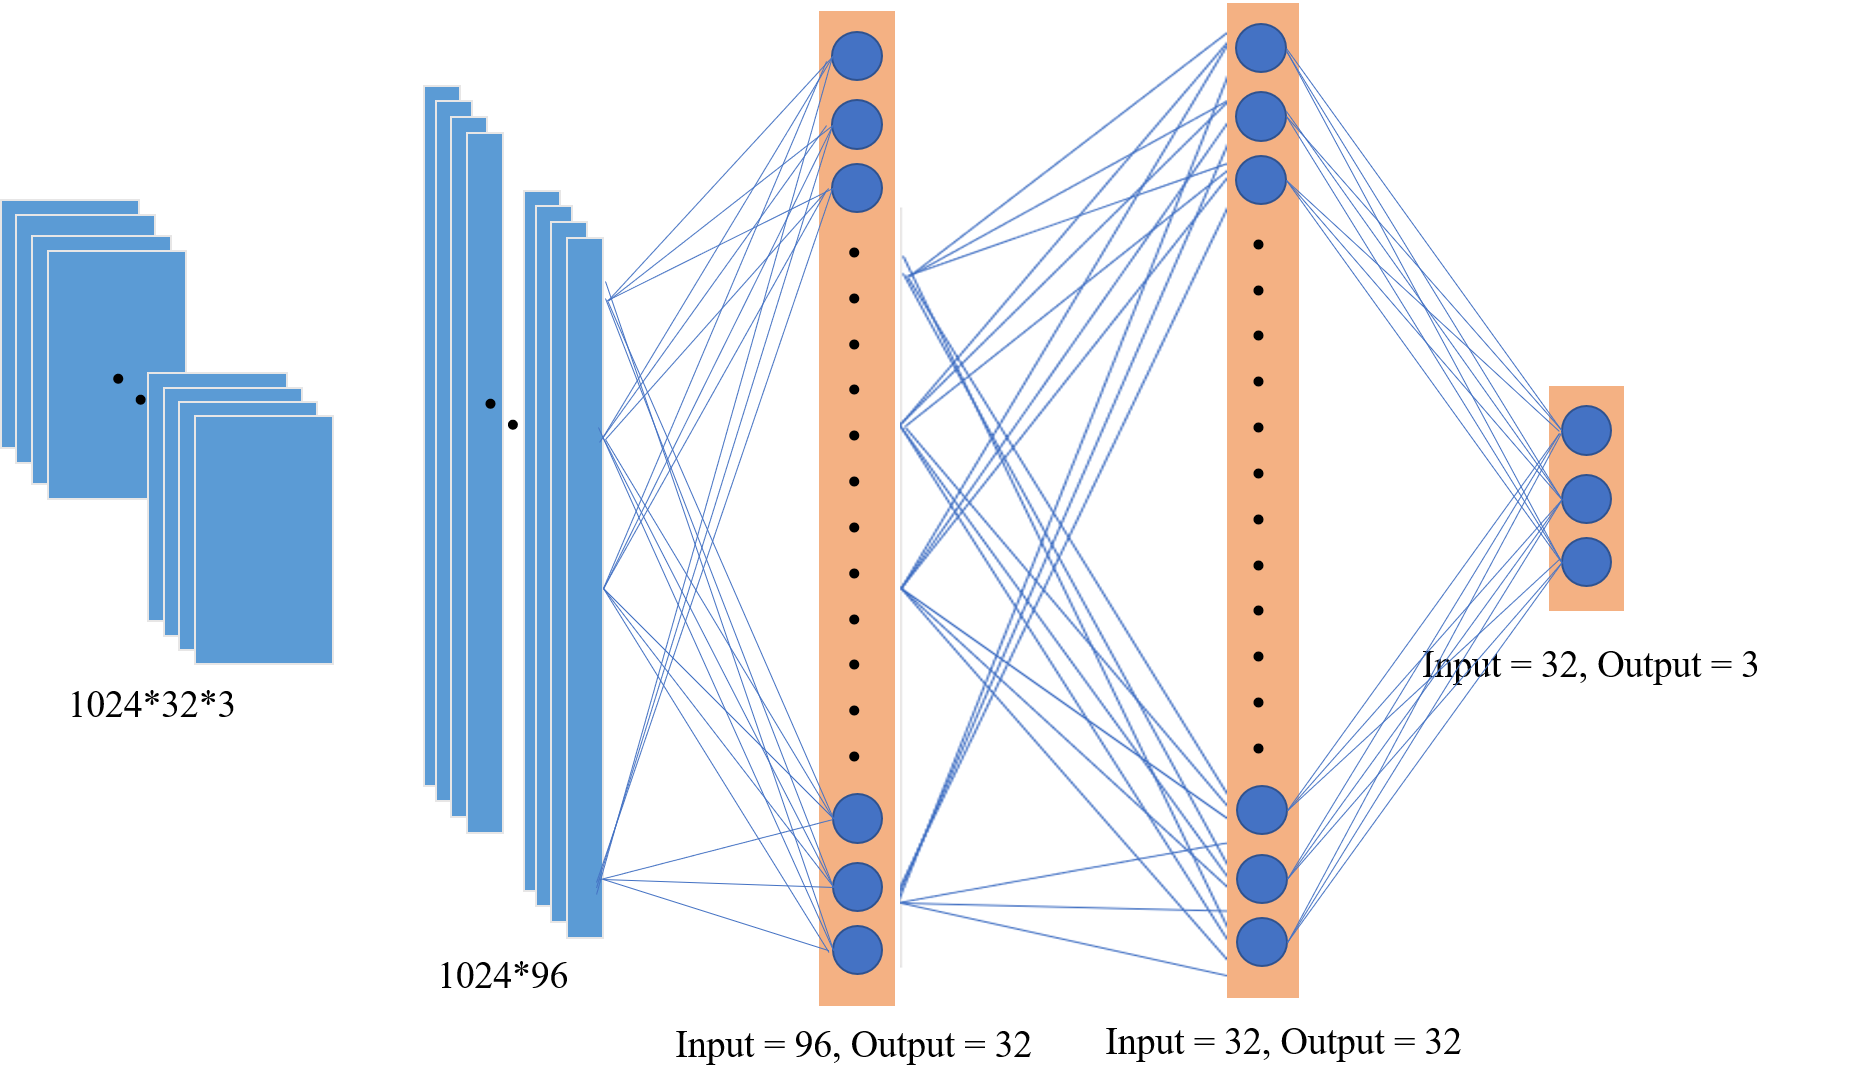

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training

In [ ]:
from torch.cuda.amp import GradScaler

def train_one_epoch(model, loader, optimizer, criterion):
    loss_sum = 0.
    scaler = GradScaler()
    losses = []
    model.train()
    for x,y,t in tqdm(loader):                               #從DataLoader中取得一個Batch size的資料
        x = x.to(cfg.device).float()
        y = y.to(cfg.device).float()
        t = t.to(cfg.device).float()
        
        y_pred = model(x)                                    #將Input x丟入模型，得到y_pred
        loss = criterion(y_pred, y)                          #計算預測結果y_pred與GT y的loss
        loss = torch.mean(loss*t.unsqueeze(-1), dim=1)
        
        t_sum = torch.sum(t)
        if t_sum > 0:
            loss = torch.sum(loss)/t_sum
        else:
            loss = torch.sum(loss)*0.
        
        # loss.backward()
        scaler.scale(loss).backward()                        #根據loss做反向傳播
        # optimizer.step()
        scaler.step(optimizer)                               #優化器優化模型參數
        scaler.update()                                      
        
        optimizer.zero_grad()                                #優化器歸零
        
        loss_sum += loss.item()
        losses.append(loss.item())
    print(f"Train Loss: {(loss_sum/len(loader)):.04f}")
    return losses

def validation_one_epoch(model, loader, criterion):
    loss_sum = 0.
    y_true_epoch = []
    y_pred_epoch = []
    t_valid_epoch = []
    
    model.eval()
    for x,y,t in tqdm(loader):
        x = x.to(cfg.device).float()
        y = y.to(cfg.device).float()
        t = t.to(cfg.device).float()
        
        with torch.no_grad():                                #沒有反向傳播
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss = torch.mean(loss*t.unsqueeze(-1), dim=1)
            
            t_sum = torch.sum(t)
            if t_sum > 0:
                loss = torch.sum(loss)/t_sum
            else:
                loss = torch.sum(loss)*0.
        
        loss_sum += loss.item()
        y_true_epoch.append(y.cpu().numpy())
        y_pred_epoch.append(y_pred.cpu().numpy())
        t_valid_epoch.append(t.cpu().numpy())
        
    y_true_epoch = np.concatenate(y_true_epoch, axis=0)
    y_pred_epoch = np.concatenate(y_pred_epoch, axis=0)
    
    t_valid_epoch = np.concatenate(t_valid_epoch, axis=0)
    y_true_epoch = y_true_epoch[t_valid_epoch > 0, :]
    y_pred_epoch = y_pred_epoch[t_valid_epoch > 0, :]
    
    scores = [average_precision_score(y_true_epoch[:,i], y_pred_epoch[:,i]) for i in range(3)]
    mean_score = np.mean(scores)
    print(f"Validation Loss: {(loss_sum/len(loader)):.04f}, Validation Score: {mean_score:.03f}, ClassWise: {scores[0]:.03f},{scores[1]:.03f},{scores[2]:.03f}")
    
    return mean_score

In [ ]:
model = FOGModel().to(cfg.device)
print(f"Number of parameters in model - {count_parameters(model):,}")

train_dataset = FOGDataset(train_fpaths, split="train")
valid_dataset = FOGDataset(valid_fpaths, split="valid")
print(f"lengths of datasets: train - {len(train_dataset)}, valid - {len(valid_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=cfg.batch_size, num_workers=5)

optimizer = getattr(torch.optim, cfg.optimizer_name)(model.parameters(), lr=cfg.lr)
criterion = getattr(torch.nn, cfg.loss_function)(reduction='none').to(cfg.device)
# sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)

max_score = 0.0

print("="*50)
losses_per_epoch = []
for epoch in range(cfg.num_epochs):
    print(f"Epoch: {epoch}")
    epoch_losses = train_one_epoch(model, train_loader, optimizer, criterion)
    losses_per_epoch.append(epoch_losses)
    score = validation_one_epoch(model, valid_loader, criterion)
    # sched.step()

    if score > max_score:
        max_score = score
        torch.save(model.state_dict(), "best_model_state.h5")      #儲存最好的模型參數
        print("Saving Model ...")

    print("="*50)
    
gc.collect()

iterations = range(len(losses_per_epoch[0]))
epochs = range(cfg.num_epochs)
plt.figure()
for epoch_losses in losses_per_epoch:
    plt.plot(iterations, epoch_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.legend(epochs)
plt.show()

# Submission

In [ ]:
model = FOGModel().to(cfg.device)
model.load_state_dict(torch.load("/kaggle/working/best_model_state.h5"))             #取得最好的模型參數
model.eval()

test_defog_paths = glob.glob("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/defog/*.csv")
test_tdcsfog_paths = glob.glob("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/test/tdcsfog/*.csv")
test_fpaths = [(f, 'de') for f in test_defog_paths] + [(f, 'tdcs') for f in test_tdcsfog_paths]

test_dataset = FOGDataset(test_fpaths, split="test")
test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, num_workers=5)

ids = []
preds = []

for _id, x, _ in tqdm(test_loader):
    x = x.to(cfg.device).float()
    with torch.no_grad():
        y_pred = model(x)*0.1
    
    ids.extend(_id)
    preds.extend(list(np.nan_to_num(y_pred.cpu().numpy())))

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/sample_submission.csv")
sample_submission.shape

In [ ]:
preds = np.array(preds)
submission = pd.DataFrame({'Id': ids, 'StartHesitation': np.round(preds[:,0],5), \
                           'Turn': np.round(preds[:,1],5), 'Walking': np.round(preds[:,2],5)})

submission = pd.merge(sample_submission[['Id']], submission, how='left', on='Id').fillna(0.0)
submission.to_csv("submission.csv", index=False)

In [ ]:
print(submission.shape)
submission.head()